In [1]:
DATA_DIR = '/lustre/groups/ml01/workspace/louis.kuemmerle/projects/A1/data2/' # "./../"
DATA_VERSION = 'oct22'
RESULTS_DIR = '/lustre/groups/ml01/workspace/louis.kuemmerle/projects/A1/results/'
SHAM = True

########################################################################################
sham_str = '_wSham' if SHAM else ''

In [2]:
import os 
import numpy as np
import itertools
import scipy as sci
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

import scanpy as sc
import anndata as ann

from scipy.sparse import csr_matrix, issparse
import matplotlib
from matplotlib import rcParams
from matplotlib import colors


sc.settings.verbosity = 3
sc.logging.print_versions()

-----
anndata     0.7.5
scanpy      1.6.1
sinfo       0.3.1
-----
PIL                 8.1.0
anndata             0.7.5
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              1.0.9
certifi             2020.12.05
cffi                1.14.4
chardet             4.0.0
cloudpickle         1.6.0
constants           NA
cycler              0.10.0
cython_runtime      NA
dask                2020.12.0
dateutil            2.8.1
decorator           4.4.2
future_fstrings     NA
get_version         2.1
google              NA
h5py                2.10.0
highs_wrapper       NA
idna                2.10
igraph              0.8.3
ipykernel           5.4.3
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              2.11.2
joblib              1.0.0
json5               NA
jsonschema          3.2.0
jupyter_server      1.2.1
jupyterlab_server   2.1.2
kiwisolver          1.3.1
legacy_api_wrap     1.2
leidenalg

In [3]:
adata = sc.read(DATA_DIR+f'cellxgene_{DATA_VERSION}{sham_str}_umaps.h5ad')

## Tspo plots for neutrophils, monocytes, B cells

In [6]:
adata = sc.read(DATA_DIR+f'cellxgene_{DATA_VERSION}{sham_str}_umaps.h5ad')
adata.obs["region"] = adata.obs["region"].cat.rename_categories({"Skull":"Calvaria"})
adata.obs["condition"] = adata.obs["condition"].cat.rename_categories({"MCAO":"MCAo"})

In [8]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors

plt.rcParams['figure.dpi'] = 70
plt.rcParams['savefig.dpi'] = 150
SMALL_SIZE = 17
MEDIUM_SIZE = 19
BIGGER_SIZE = 21
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

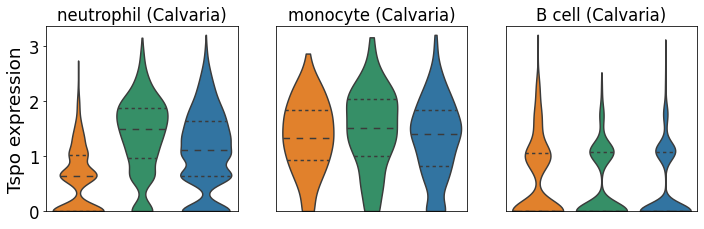

,neutrophil Tspo median,monocyte Tspo median,B cell Tspo median
Naive,0.636112,1.347404,0.0
Sham,1.488795,1.534962,0.0
MCAo,1.112495,1.424078,0.0


In [26]:
from matplotlib import gridspec

gene = "Tspo"
bones = ["Calvaria"]#,"Vertebra","Scapula","Humerus","Femur","Pelvis"]
cts = ["neutrophil","monocyte","B cell"]

ncols=len(bones)
nrows=len(cts)

fig = plt.figure(figsize=(4*nrows, 3.5*ncols))

gs = gridspec.GridSpec(ncols, nrows,wspace=0.20, hspace=0.20)

#fig, axs = plt.subplots(len(adata.obs["level1"].unique()), 2, figsize=(12,len(adata.obs["level1"].unique())*4))

df_median = pd.DataFrame(index=["Naive","Sham","MCAo"])

for col,ct in enumerate(cts):
    minimum = np.min(adata[(adata.obs["level1"]==ct) & adata.obs["region"].isin(bones),gene].X)
    maximum = np.max(adata[(adata.obs["level1"]==ct) & adata.obs["region"].isin(bones),gene].X) * 1.05
    for row,bone in enumerate(bones):
        a = adata[(adata.obs["level1"]==ct) & (adata.obs["region"]==bone)]
        
        ax=plt.subplot(gs[row,col])      
        stripplot = a.n_obs < 200
        sc.pl.violin(a, gene,groupby="condition",stripplot=stripplot,
                     order=["Naive","Sham","MCAo"],show=False,ax=ax,inner="quartile")
        plt.title(f"{ct} ({bone})")
        df_tmp = pd.DataFrame(data={gene:np.array(a[:,gene].X.toarray())[:,0], "condition":a.obs["condition"].values}).groupby("condition").median()
        df_median[f"{ct} {gene} median"] = df_tmp.loc[["Naive","Sham","MCAo"],gene].values
        
        plt.ylim([minimum,maximum])
        plt.xlabel("")   
        if col == 0:
            plt.ylabel(f"{gene} expression")
        else:
            ax.set(yticks=[])
            plt.ylabel("")
        if row != (nrows-1):
            ax.set(xticks=[])
        #else:
        #    ax.set_xticklabels(ax.get_xticklabels(), rotation = 30, ha="right")        
plt.show()
fig.savefig(f"./figures/{gene}_violins_condition_{'_'.join(bones)}.png", bbox_inches = "tight") 
df_median.to_csv(f"./figures/{gene}_violins_condition_{'_'.join(bones)}_median_exprs.csv")

display(df_median)


In [33]:
df_median.T.applymap(lambda x: float(f"{x:.2f}"))

,Naive,Sham,MCAo
neutrophil Tspo median,0.64,1.49,1.11
monocyte Tspo median,1.35,1.53,1.42
B cell Tspo median,0.00,0.00,0.00


# Naive vs injury violins

In [6]:
adata = sc.read(DATA_DIR+f'cellxgene_{DATA_VERSION}{sham_str}_umaps.h5ad')

In [7]:
a = adata[(adata.obs["region"] == "Skull") & (adata.obs["level1"] == "neutrophil"), "Tspo"].copy()

In [8]:
a.obs["Injury_vs_Naive"] = a.obs["condition"].astype(str)
a.obs.loc[a.obs["Injury_vs_Naive"].isin(["MCAO","Sham"]),"Injury_vs_Naive"] = "Injury"

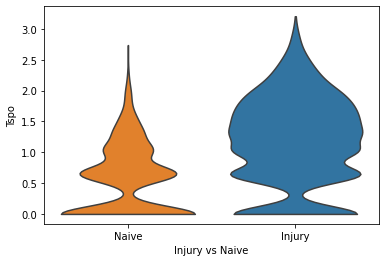

In [16]:
fig= plt.figure(figsize=(6,4))

sc.pl.violin(a, "Tspo",groupby="Injury_vs_Naive",stripplot=False,
             order=["Naive","Injury"],show=False,ax=plt.gca())

plt.show()
fig.savefig("./figures/Tspo_naive_vs_injury_violins.pdf", bbox_inches = "tight") 

In [10]:
sc.tl.rank_genes_groups(a, groupby="Injury_vs_Naive")

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


In [11]:
a.uns["rank_genes_groups"]

{'params': {'groupby': 'Injury_vs_Naive',
  'reference': 'rest',
  'method': 't-test',
  'use_raw': True,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('Tspo', 'Tspo')],
           dtype=[('Injury', 'O'), ('Naive', 'O')]),
 'scores': rec.array([(36.48013, -36.48013)],
           dtype=[('Injury', '<f4'), ('Naive', '<f4')]),
 'pvals': rec.array([(6.04859944e-245, 6.04859944e-245)],
           dtype=[('Injury', '<f8'), ('Naive', '<f8')]),
 'pvals_adj': rec.array([(6.04859944e-245, 6.04859944e-245)],
           dtype=[('Injury', '<f8'), ('Naive', '<f8')]),
 'logfoldchanges': rec.array([(1.5344537, -1.5344537)],
           dtype=[('Injury', '<f4'), ('Naive', '<f4')])}

# p values for Tspo expression

In [4]:
bones = ["Skull","Vertebra","Scapula","Humerus","Femur","Pelvis"]

df = pd.DataFrame(index=adata.obs["level1"].unique(),columns=bones)
for b in bones:
    a = adata[adata.obs["region"] == b, "Tspo"].copy()
    a.obs["injury_vs_naive"] = a.obs["condition"].astype(str)
    a.obs.loc[a.obs["injury_vs_naive"].isin(["MCAO","Sham"]),"injury_vs_naive"] = "injury"
    for ct in adata.obs["level1"].unique():
        try:
            a_tmp = a[a.obs["level1"] == ct].copy()
            sc.tl.rank_genes_groups(a_tmp, groupby="injury_vs_naive")
            df.loc[ct,b] = a_tmp.uns["rank_genes_groups"]["pvals_adj"]["injury"][0]
        except:
            print(f"Didn't work: {b}, {ct}")

ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


Didn't work: Skull, innate lymphoid cell
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


Didn't work: Skull, megakaryocyte
ranking genes
Didn't work: Skull, microglia
ranking genes
Didn't work: Skull, brain cell
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


Didn't work: Vertebra, innate lymphoid cell
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes
Didn't work: Vertebra, megakaryocyte
ranking genes
Didn't work: Vertebra, microglia
ranking genes
Didn't work: Vertebra, brain cell
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


Didn't work: Scapula, megakaryocyte
ranking genes
Didn't work: Scapula, microglia
ranking genes
Didn't work: Scapula, brain cell
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


Didn't work: Humerus, innate lymphoid cell
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


Didn't work: Humerus, megakaryocyte
ranking genes
Didn't work: Humerus, microglia
ranking genes
Didn't work: Humerus, brain cell
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


Didn't work: Femur, innate lymphoid cell
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes
Didn't work: Femur, microglia
ranking genes
Didn't work: Femur, brain cell
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


... storing 'injury_vs_naive' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes
Didn't work: Pelvis, megakaryocyte
ranking genes
Didn't work: Pelvis, microglia
ranking genes


... storing 'injury_vs_naive' as categorical


Didn't work: Pelvis, brain cell


In [23]:
def highlight_significant(x, color):
    return np.where((x < 0.05), f"color: {color};", None)

In [24]:
df.style.apply(highlight_significant, color='green')

,Skull,Vertebra,Scapula,Humerus,Femur,Pelvis
neutrophil,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
B cell,0.000002,0.000423,0.343229,0.000000,0.000000,0.000000
monocyte,0.764435,0.032207,0.000000,0.000072,0.368107,0.000739
erythroid cell,0.082310,0.010238,0.000013,0.003012,0.000000,0.000000
progenitors,0.845714,0.009946,0.000000,0.786912,0.806210,0.024256
erythroid precursor,0.548581,0.811877,0.000000,0.269274,0.000199,0.689584
basophil,0.039452,0.002757,0.594601,0.006935,0.389616,0.044673
dendritic cell,0.340031,0.895791,0.000002,0.001782,0.540019,0.010145
NK cell,0.153350,0.262552,0.052404,0.471830,0.000000,0.487818
T cell,0.037788,0.656053,0.015629,0.865455,0.970476,0.186107


In [5]:
df

,Skull,Vertebra,Scapula,Humerus,Femur,Pelvis
neutrophil,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
B cell,0.000002,0.000423,0.343229,0.000000,0.000000,0.000000
monocyte,0.764435,0.032207,0.000000,0.000072,0.368107,0.000739
erythroid cell,0.082310,0.010238,0.000013,0.003012,0.000000,0.000000
progenitors,0.845714,0.009946,0.000000,0.786912,0.806210,0.024256
erythroid precursor,0.548581,0.811877,0.000000,0.269274,0.000199,0.689584
basophil,0.039452,0.002757,0.594601,0.006935,0.389616,0.044673
dendritic cell,0.340031,0.895791,0.000002,0.001782,0.540019,0.010145
NK cell,0.153350,0.262552,0.052404,0.471830,0.000000,0.487818
T cell,0.037788,0.656053,0.015629,0.865455,0.970476,0.186107
